<h1 style="text-align: center;">Лабораторная работа №3</h1>




*  ФИО: Лучер Дмитрий

*  Номер группы: 5130901/20103

* SOM

* [Дасатсет](https://www.kaggle.com/datasets/sylkaladin/speech-commands-v2/data)

# Импорт библиотек

In [2]:
import tensorflow as tf
import numpy as np
import random
import os

def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [3]:
import os
import shutil
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import pandas as pd
import librosa
import random
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from collections import defaultdict, Counter
from minisom import MiniSom

# Загрузка набора данных

In [ ]:
# Defining paths
dataset_dir = "numbers/"
classes_names = ['zero','one','two','three','four','five','six','seven','eight','nine']
classes_paths = [os.path.join(dataset_dir,x) for x in classes_names]

In [ ]:
all_files_names = [] 
for class_path in classes_paths:
    current_class_files_paths = os.listdir(class_path)
    all_files_names.append(current_class_files_paths)

# Чтение аудио

In [ ]:
full_files_paths = []
classes = []

for class_index, class_files in enumerate(all_files_names):
    for file_name in class_files:
        full_file_path = os.path.join(classes_paths[class_index],file_name)
        full_files_paths.append(full_file_path)
        classes.append(class_index)

In [ ]:
audios_data = []
srs_data = []
for file_path in full_files_paths:
    audio, sr = librosa.load(file_path)
    audios_data.append(audio)
    srs_data.append(sr)

In [ ]:
all_audios_data = audios_data
all_srs = srs_data 
all_classes = classes

# Нормализация данных

In [ ]:
all_audios_normalized = []
for audio in all_audios_data:
    normalized_audio = librosa.util.normalize(audio)
    all_audios_normalized.append(normalized_audio)

# Особенности извлечения

In [ ]:
all_features = []
for index, audio in enumerate(all_audios_normalized):
    sr = all_srs[index]
    mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13).T, axis=0)
    all_features.append(mfcc)

print(len(all_features))

In [ ]:
X=np.array(all_features) # converts the list to numpy array
y = np.array(all_classes) # converts the list to numpy array
np.save('data/X.npy', X)
np.save('data/y4.npy', y)

# Загрузка признаков и меток классов
X содержит признаки, yz — соответствующие им классы


In [419]:
# === Загрузка данных ===
X = np.load('data/X5.npy')  # features
yz = np.load('data/y5.npy')  # labels

In [420]:
# === Нормализация ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Инициализация и обучение карты Кохонена (SOM)
Размер карты: 15x15, радиус сигма — 4.0, скорость обучения — 0.005

In [479]:
# === Обучение SOM ===
N =10
som_shape = (15,15)  # можно изменить
som = MiniSom(som_shape[0], som_shape[1], X_scaled.shape[1], sigma=4.0, learning_rate=0.005,
              neighborhood_function='gaussian', random_seed=42)
som.train_batch(X_scaled,400000, verbose=True)

 [ 400000 / 400000 ] 100% - 0:00:00 left 
 quantization error: 0.32225023656849766


# Построение распределения классов по нейронам (Pie Charts)

In [480]:
# === Построение распределения классов по нейронам ===
winner_coordinates = np.array([som.winner(x) for x in X_scaled])
label_map = defaultdict(list)

for coord, label in zip(winner_coordinates, yz):
    label_map[tuple(coord)].append(label)

colors = sns.color_palette("tab10", N)  # 10 уникальных цветов
label_names = ['zero','one','two','three','four','five','six','seven','eight','nine'][:N]

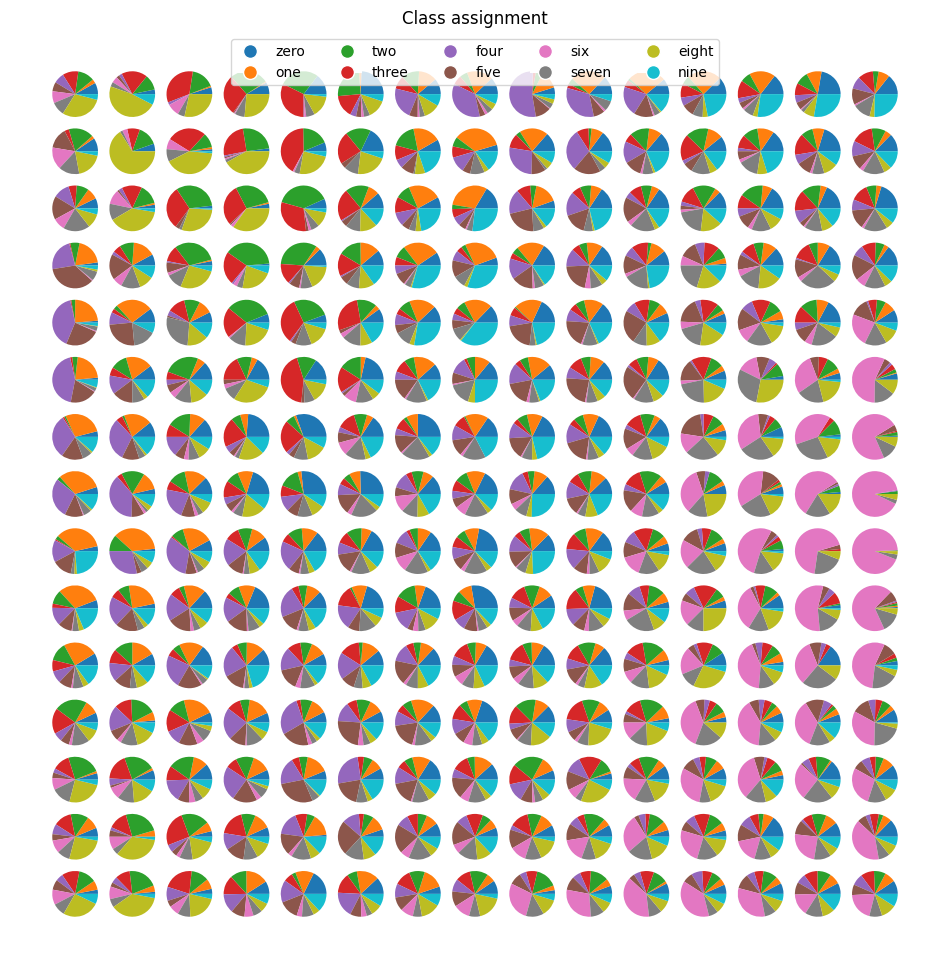

In [481]:
plt.figure(figsize=(12, 12))

for x in range(som_shape[0]):
    for y in range(som_shape[1]):
        labels = label_map.get((x, y), [])
        if not labels:
            continue
        counts = [labels.count(i) for i in range(N)]
        total = sum(counts)
        if total == 0:
            continue
        fracs = [c / total for c in counts]
        plt.pie(fracs, colors=colors, radius=0.4,
                center=(x, som_shape[1] - y - 1))

plt.title("Class assignment")
patches = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                      markerfacecolor=color, markersize=10)
           for label, color in zip(label_names, colors)]
plt.legend(handles=patches, loc='upper center', ncol=5)
plt.axis('equal')
plt.show()



# Отображение наиболее частого класса на нейроне

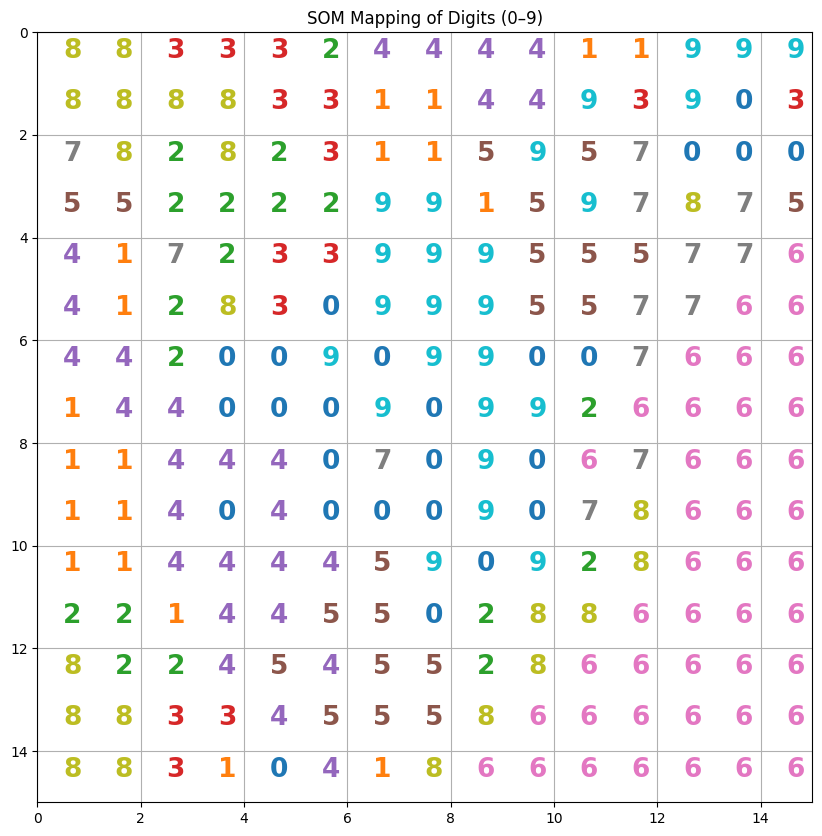

In [482]:
plt.figure(figsize=(10, 10))
wmap = defaultdict(list)

for x_vec, label in zip(X_scaled, yz):
    w = som.winner(x_vec)
    wmap[w].append(label)

for coord, labels in wmap.items():
    most_common_label = Counter(labels).most_common(1)[0][0]
    plt.text(coord[0] + 0.5, coord[1] + 0.5, str(most_common_label),
             color=plt.cm.tab10(most_common_label / 10),
             fontdict={'weight': 'bold', 'size': 19})

plt.axis([0, som_shape[0], 0, som_shape[1]])
plt.title("SOM Mapping of Digits (0–9)")
plt.grid(True)
plt.gca().invert_yaxis()  # для согласованности с pie-картой
plt.savefig('som_digits.png')
plt.show()



# Визуализация U-Matrix

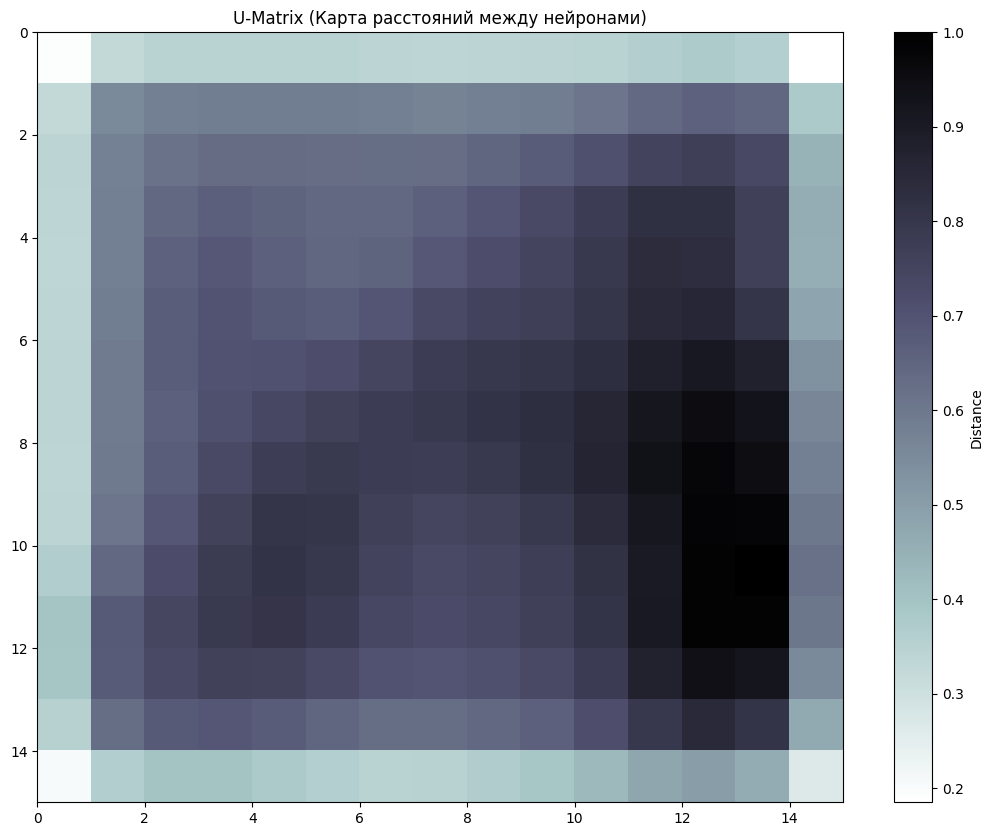

In [504]:
plt.figure(figsize=(13,10))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # транспонируем для совпадения с SOM-координатами
plt.colorbar(label='Distance')
plt.title("U-Matrix (Карта расстояний между нейронами)")
plt.gca().invert_yaxis()  # Чтобы совпадало с предыдущей визуализацией
plt.show()



# Гистограмма ошибок квантования

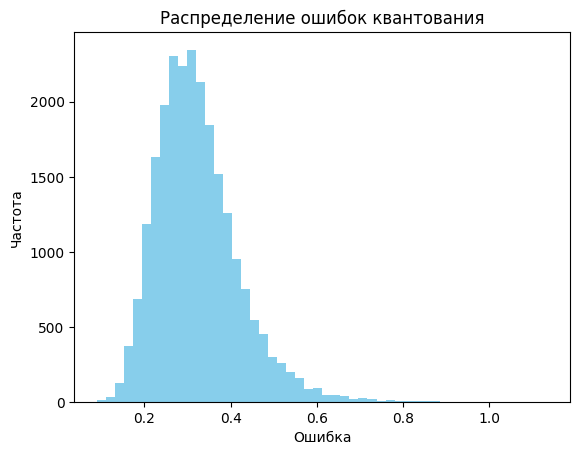

In [485]:
q_errors = [som.quantization_error([x]) for x in X_scaled]
plt.hist(q_errors, bins=50, color='skyblue')
plt.title("Распределение ошибок квантования")
plt.xlabel("Ошибка")
plt.ylabel("Частота")
plt.show()


# t-SNE проекция весов SOM

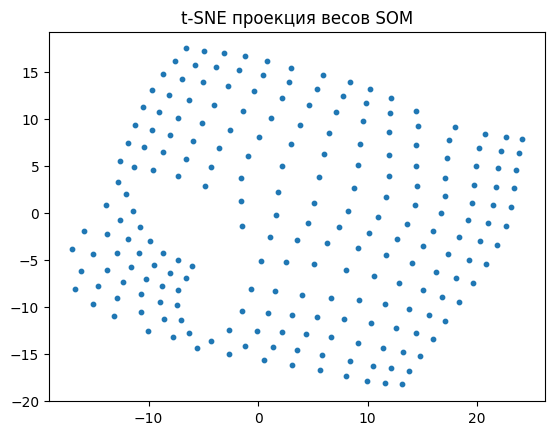

In [489]:
from sklearn.manifold import TSNE
weights = som.get_weights().reshape(-1, X_scaled.shape[1])
tsne = TSNE(n_components=2, random_state=42)
weights_2d = tsne.fit_transform(weights)

plt.scatter(weights_2d[:, 0], weights_2d[:, 1], s=10)
plt.title("t-SNE проекция весов SOM")
plt.show()


# Тепловая карта распределения классов



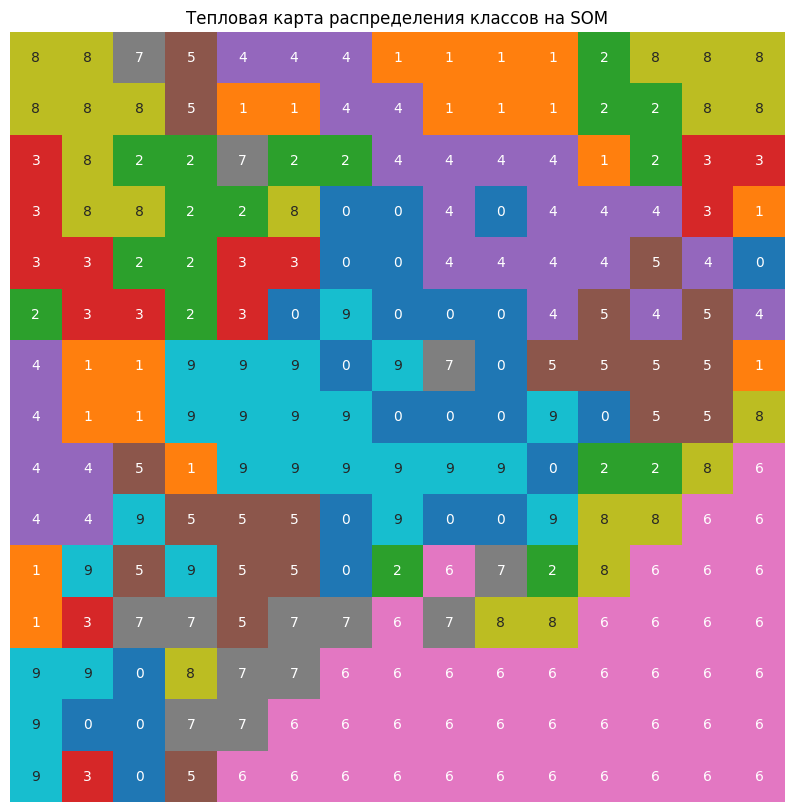

In [491]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Получение карты классов для каждого нейрона
class_map = np.zeros(som_shape)
for (x, y), labels in label_map.items():
    most_common_label = Counter(labels).most_common(1)[0][0]
    class_map[x, y] = most_common_label

# Визуализация тепловой карты
plt.figure(figsize=(10, 10))
sns.heatmap(class_map, annot=True, cmap="tab10", cbar=False, xticklabels=False, yticklabels=False)
plt.title("Тепловая карта распределения классов на SOM")
plt.show()
